In [1]:
from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import anndata as ad
from sklearn.decomposition import PCA

ModuleNotFoundError: No module named 'sklearn'

In [40]:
metadata = pd.read_csv('../data/metadata_rxrx3.csv')
metadata.head()

/var/folders/t0/mvqcnrsn7cb969y_xj3wlv1m0000gn/T/ipykernel_50543/3262105939.py:1: DtypeWarning:

Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.



,well_id,experiment_name,plate,address,gene,treatment,SMILES,concentration,perturbation_type,cell_type
0,gene-044_6_I27,gene-044,6,I27,RXRX3-65482,RXRX3-65482_guide_3,NaN,NaN,CRISPR,HUVEC
1,compound-003_11_AD37,compound-003,11,AD37,NaN,Phloretin,"OC1=CC=C(CCC(=O)C2=C(O)C=C(O)C=C2O)C=C1 |c:9,1...",0.025,COMPOUND,HUVEC
2,gene-065_5_O32,gene-065,5,O32,RXRX3-44488,RXRX3-44488_guide_1,NaN,NaN,CRISPR,HUVEC
3,gene-021_3_X40,gene-021,3,X40,RXRX3-36525,RXRX3-36525_guide_1,NaN,NaN,CRISPR,HUVEC
4,gene-041_2_AD47,gene-041,2,AD47,RXRX3-98689,RXRX3-98689_guide_3,NaN,NaN,CRISPR,HUVEC


In [2]:
adata = ad.read_h5ad('../data/egfr_embeddings.h5ad')
adata


AnnData object with n_obs × n_vars = 457 × 128
    obs: 'experiment_name', 'plate', 'address', 'gene', 'treatment', 'SMILES', 'concentration', 'perturbation_type', 'cell_type'

In [11]:
# If `treatment` contains "EGFR" then label it just EGFRi
adata.obs['treatment'] = adata.obs['treatment'].apply(lambda x: 'EGFRi' if 'EGFR' in x else x)

In [12]:
# Standardize the data
adata.X = (adata.X - adata.X.mean(axis=0)) / adata.X.std(axis=0)


PCA(n_components=2)

<Axes: >

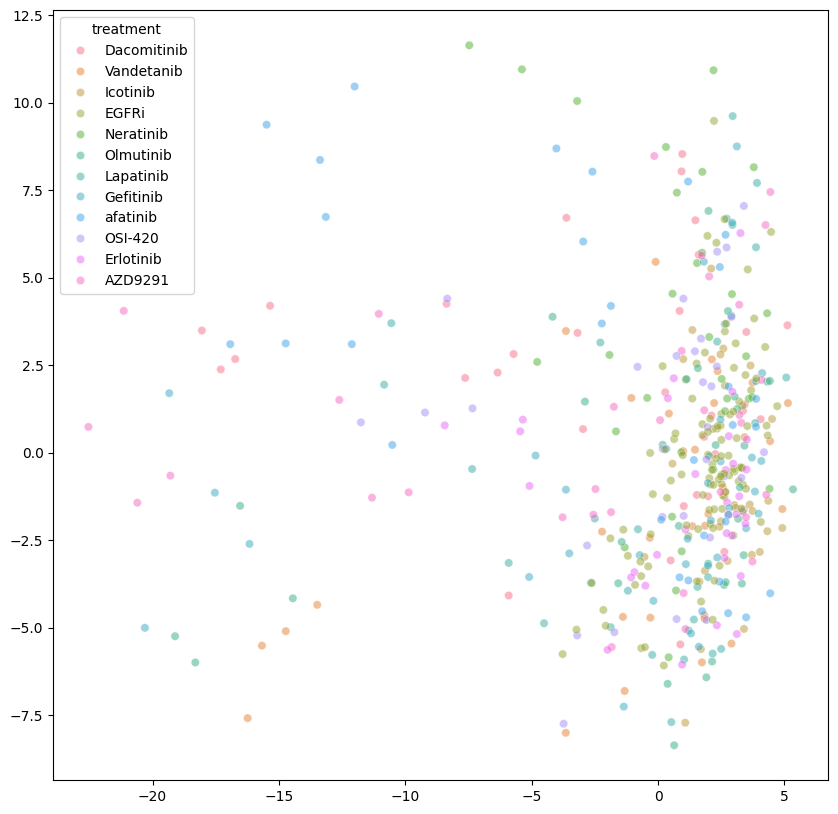

In [13]:
# Run and plot PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(adata.X)
adata.obsm['X_pca'] = pca.transform(adata.X)

# Plot the PCA
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x=adata.obsm['X_pca'][:, 0], y=adata.obsm['X_pca'][:, 1], hue=adata.obs.treatment, alpha=0.5)
plt.show()

In [39]:
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import scanpy as sc

def plot_comparative_tsne(adata, treatment_col='treatment', color_by='concentration', 
                         perplexity=30, random_state=42, n_iter=1000,
                         save_html=None, return_fig=True):
    """
    Create interactive t-SNE visualization with improved treatment and concentration display
    """
    # Print diagnostic information
    print("\nUnique concentrations:", sorted(adata.obs[color_by].unique()))
    print("Unique treatments:", sorted(adata.obs[treatment_col].unique()))
    
    # Get coordinates
    tsne_coords = adata.obsm['X_tsne']
    
    # Create DataFrame for plotting
    import pandas as pd
    plot_df = pd.DataFrame({
        'tsne1': tsne_coords[:, 0],
        'tsne2': tsne_coords[:, 1],
        'Treatment': adata.obs[treatment_col].astype(str),
        'Concentration': adata.obs[color_by].astype(float),
        'Log_Concentration': np.log10(adata.obs[color_by].astype(float)),
        'Leiden_cluster': adata.obs['leiden'].astype(str)
    })
    
    # Create figure
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=('Leiden Clusters', 'Treatment Groups'),
        horizontal_spacing=0.1
    )
    
    # Plot 1: Leiden clusters
    cluster_colors = px.colors.qualitative.Set3
    for i, cluster in enumerate(sorted(plot_df['Leiden_cluster'].unique())):
        mask = plot_df['Leiden_cluster'] == cluster
        fig.add_trace(
            go.Scatter(
                x=plot_df.loc[mask, 'tsne1'],
                y=plot_df.loc[mask, 'tsne2'],
                mode='markers',
                name=f'Cluster {cluster}',
                marker=dict(
                    size=8,
                    color=cluster_colors[i % len(cluster_colors)]
                ),
                showlegend=bool(True)  # Explicit boolean conversion
            ),
            row=1, col=1
        )
    
    # Plot 2: Treatments with concentration coloring
    # Create markers for treatments
    markers = ['circle', 'square', 'diamond', 'cross', 'x', 'triangle-up', 
              'triangle-down', 'triangle-left', 'triangle-right', 'pentagon', 
              'star', 'hexagram']
    
    for i, treatment in enumerate(sorted(plot_df['Treatment'].unique())):
        mask = plot_df['Treatment'] == treatment
        fig.add_trace(
            go.Scatter(
                x=plot_df.loc[mask, 'tsne1'],
                y=plot_df.loc[mask, 'tsne2'],
                mode='markers',
                name=treatment,
                marker=dict(
                    size=8,
                    symbol=markers[i % len(markers)],
                    color=plot_df.loc[mask, 'Log_Concentration'],
                    colorscale='Viridis',
                    showscale=bool(i == 0),  # Only show colorbar for first trace
                    colorbar=dict(
                        title='Log10 Concentration (µM)',
                        tickmode='array',
                        ticktext=[f'{c:.1f}' for c in sorted(plot_df['Log_Concentration'].unique())],
                        tickvals=sorted(plot_df['Log_Concentration'].unique())
                    )
                ),
                showlegend=bool(True)  # Explicit boolean conversion
            ),
            row=1, col=2
        )
    
    # Update layout
    fig.update_layout(
        title={
            'text': 't-SNE Visualization<br>Left: Leiden Clusters, Right: Treatments colored by Log10 Concentration',
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        },
        width=1600,
        height=800,
        template='plotly_white',
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=1.05,
            title=dict(text="<b>Clusters | Treatments</b>")
        )
    )
    
    # Update axes
    for i in [1, 2]:
        fig.update_xaxes(title_text="t-SNE 1", row=1, col=i)
        fig.update_yaxes(title_text="t-SNE 2", row=1, col=i)
    
    if save_html:
        fig.write_html(save_html)
        print(f"Figure saved to {save_html}")
    
    return fig

# Print diagnostic information before running
print("Data summary:")
print("\nNumber of cells:", adata.n_obs)
print("Number of clusters:", len(adata.obs['leiden'].unique()))
print("Concentration range:", adata.obs['concentration'].min(), "to", adata.obs['concentration'].max(), "µM")
print("Number of treatments:", len(adata.obs['treatment'].unique()))

# Create visualization
fig = plot_comparative_tsne(
    adata, 
    treatment_col='treatment', 
    color_by='concentration',
    save_html='tsne_visualization_fixed.html'
)

# Display diagnostic information about the plot
print("\nPlot has been created. Please check:")
print("1. All treatments are shown with unique markers")
print("2. Concentration colorbar shows proper log scale")
print("3. Leiden clusters are clearly distinguishable")

Data summary:

Number of cells: 457
Number of clusters: 9
Concentration range: 0.0025 to 10.0 µM
Number of treatments: 12

Unique concentrations: [0.0025, 0.01, 0.025, 0.1, 0.25, 1.0, 2.5, 10.0, nan]
Unique treatments: ['AZD9291', 'Dacomitinib', 'EGFRi', 'Erlotinib', 'Gefitinib', 'Icotinib', 'Lapatinib', 'Neratinib', 'OSI-420', 'Olmutinib', 'Vandetanib', 'afatinib']
Figure saved to tsne_visualization_fixed.html

Plot has been created. Please check:
1. All treatments are shown with unique markers
2. Concentration colorbar shows proper log scale
3. Leiden clusters are clearly distinguishable


In [28]:
'treatment' in adata.obs

True